### 💻 **Cloud Backup Data Integrity Anomalies**

### 🎯 **Project Objective**

**Objective**:  
Detect anomalies in cloud backup data, such as corruption in stored data or failed backup jobs. Anomalies in backup integrity can include missing files, incomplete backups, or inconsistencies between local and cloud data. Early detection ensures that backup processes are functioning correctly, reducing the risk of data loss and improving system reliability.

### 🧾 **Feature List**

In [1]:
feature_list = [
    'user_id',                      # Unique identifier for each user
    'total_files_in_backup',        # Total number of files that should be included in the backup
    'files_backed_up',              # Number of files successfully backed up to the cloud
    'backup_success_rate',          # Percentage of successful backup operations
    'backup_duration_minutes',      # Duration of the backup operation in minutes
    'backup_time_of_day',           # The time of day when the backup occurred (morning, afternoon, evening)
    'backup_type',                  # Type of backup (full, incremental)
    'local_data_size_GB',           # Total size of the data to be backed up on the local machine (in GB)
    'cloud_data_size_GB',           # Total size of data stored in the cloud after backup (in GB)
    'failed_backups',               # Number of failed backup attempts in the last 30 days
    'backup_errors',                # Number of errors encountered during the backup process
    'missing_files',                # Number of files that were supposed to be included in the backup but are missing
    'backup_frequency',             # Frequency of backups (e.g., daily, weekly)
    'backup_status'                 # Binary variable indicating whether the backup was successful (1) or failed (0)
]


### 📦 **Step 1: Import Required Libraries**

In [2]:
import pandas as pd
import numpy as np
import random
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
import seaborn as sns
import matplotlib.pyplot as plt

### 🧑‍💻 **Step 2: Generate Synthetic User Behavior Data**

In [3]:
# Generate synthetic data
def simulate_backup_data(num_samples):
    data = pd.DataFrame({
        'user_id': range(num_samples),
        'total_files_in_backup': np.random.randint(500, 5000, num_samples),  # Total files in backup
        'files_backed_up': np.random.randint(400, 5000, num_samples),  # Number of files successfully backed up
        'backup_success_rate': np.random.uniform(85, 100, num_samples),  # Backup success rate (percentage)
        'backup_duration_minutes': np.random.uniform(30, 120, num_samples),  # Duration of the backup in minutes
        'backup_time_of_day': np.random.choice(['morning', 'afternoon', 'evening'], num_samples),  # Time of day
        'backup_type': np.random.choice(['full', 'incremental'], num_samples),  # Full or incremental backup
        'local_data_size_GB': np.random.uniform(1, 500, num_samples),  # Local data size in GB
        'cloud_data_size_GB': np.random.uniform(1, 500, num_samples),  # Cloud data size in GB
        'failed_backups': np.random.randint(0, 5, num_samples),  # Number of failed backup attempts
        'backup_errors': np.random.randint(0, 5, num_samples),  # Number of backup errors
        'missing_files': np.random.randint(0, 20, num_samples),  # Number of missing files
        'backup_frequency': np.random.choice(['daily', 'weekly'], num_samples),  # Backup frequency
        'backup_status': np.random.choice([0, 1], num_samples, p=[0.1, 0.9])  # Backup status: 1 for success, 0 for failure
    })
    return data

# Generate synthetic test data
test_data = simulate_backup_data(200)

# Inject anomalies (failed backups, missing files, errors)
anomaly_indices = random.sample(range(len(test_data)), 10)  # Select random indices for anomalies
test_data.iloc[anomaly_indices, 1] += 100  # Inflate number of files backed up (simulate missing files)
test_data.iloc[anomaly_indices, 4] += 50  # Inflate backup duration (simulate failed backup)
test_data.iloc[anomaly_indices, 9] += 3   # Inflate number of backup errors
test_data.iloc[anomaly_indices, 10] += 5  # Inflate missing files

# Ensure that categorical features are properly encoded
test_data_encoded = test_data.copy()
test_data_encoded['backup_time_of_day'] = test_data_encoded['backup_time_of_day'].astype('category').cat.codes
test_data_encoded['backup_type'] = test_data_encoded['backup_type'].astype('category').cat.codes
test_data_encoded['backup_frequency'] = test_data_encoded['backup_frequency'].astype('category').cat.codes

# Double-check the data types after encoding
print(test_data_encoded.dtypes)

# Standardizing or scaling the test data (make sure all columns are numerical)
scaler = StandardScaler()
test_data_scaled = scaler.fit_transform(test_data_encoded.drop(columns=['user_id', 'backup_status']))

user_id                      int64
total_files_in_backup        int32
files_backed_up              int32
backup_success_rate        float64
backup_duration_minutes    float64
backup_time_of_day            int8
backup_type                   int8
local_data_size_GB         float64
cloud_data_size_GB         float64
failed_backups               int32
backup_errors                int32
missing_files                int32
backup_frequency              int8
backup_status                int32
dtype: object


### 🤖 **Step 3: Train the Model Using Isolation Forest**

In [4]:
# Define the model for anomaly detection (Isolation Forest)
model = IsolationForest(contamination=0.05)  # Assume 5% of data are anomalies
model.fit(test_data_scaled)

# Predict anomalies on the test data
test_data_encoded['predicted_anomaly'] = model.predict(test_data_scaled)
test_data_encoded['predicted_anomaly'] = test_data_encoded['predicted_anomaly'].map({1: 0, -1: 1})  # 0 for normal, 1 for anomaly

# Extract anomalies for inspection
anomalies = test_data_encoded[test_data_encoded['predicted_anomaly'] == 1]

# Display the detected anomalies
anomalies.head()

,user_id,total_files_in_backup,files_backed_up,backup_success_rate,backup_duration_minutes,backup_time_of_day,backup_type,local_data_size_GB,cloud_data_size_GB,failed_backups,backup_errors,missing_files,backup_frequency,backup_status,predicted_anomaly
29,29,1081,4116,89.669636,150.506086,2,1,69.566632,29.179239,7,8,17,1,1,1
47,47,4066,1706,90.680914,150.881380,1,0,183.661076,382.873684,7,9,1,1,1,1
66,66,4905,2933,99.382409,46.395998,1,1,469.491640,477.845328,0,4,18,1,1,1
82,82,1522,2811,92.526769,144.048818,0,1,108.172129,20.330717,3,5,5,0,1,1
115,115,1679,1035,94.670046,149.700539,2,1,245.838919,417.001783,7,5,19,1,1,1


### 📈 **Step 4: Plot Anomaly Scores Distribution**

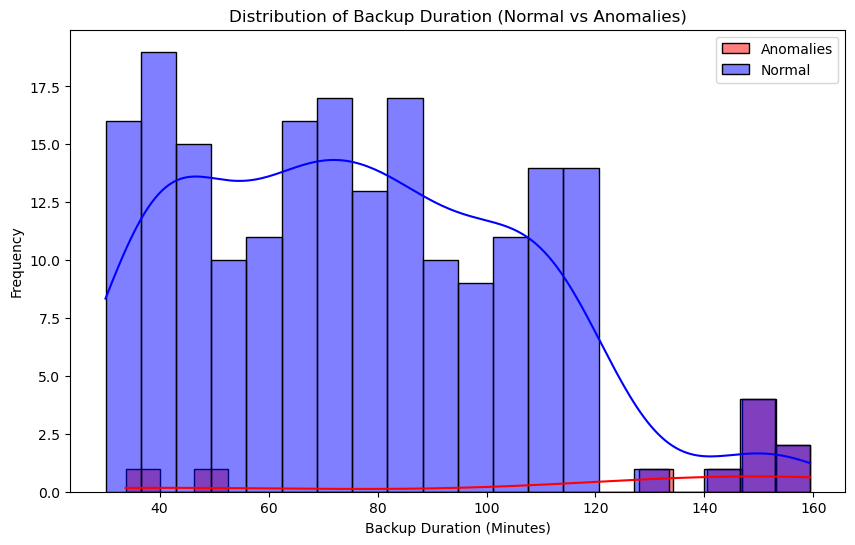

In [5]:
# Plot anomaly distribution (Backup duration and missing files)
plt.figure(figsize=(10, 6))
sns.histplot(anomalies['backup_duration_minutes'], bins=20, color='red', label="Anomalies", kde=True)
sns.histplot(test_data_encoded['backup_duration_minutes'], bins=20, color='blue', label="Normal", kde=True)
plt.title("Distribution of Backup Duration (Normal vs Anomalies)")
plt.xlabel("Backup Duration (Minutes)")
plt.ylabel("Frequency")
plt.legend()
plt.show()

### 📈 **Step 5: Evaluate Model Performance**

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       190
           1       0.10      0.10      0.10        10

    accuracy                           0.91       200
   macro avg       0.53      0.53      0.53       200
weighted avg       0.91      0.91      0.91       200



C:\Users\USER\AppData\Local\Temp\ipykernel_12840\3310763794.py:22: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from current font.
  plt.tight_layout()
C:\Users\USER\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


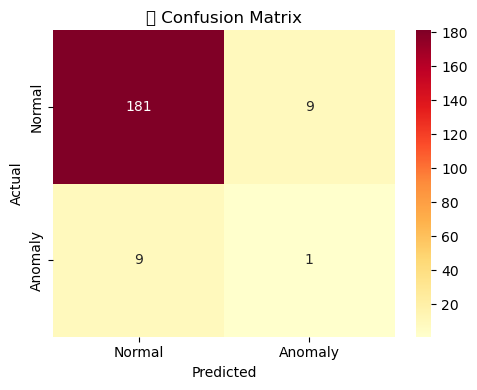

In [6]:
from sklearn.metrics import classification_report, confusion_matrix

anomaly_indices = random.sample(range(len(test_data)), 10)

# Step 1: Create ground truth (true labels)
test_data_encoded['true_label'] = 0
test_data_encoded.loc[anomaly_indices, 'true_label'] = 1

# Step 2: Classification report
print("📊 Classification Report:")
print(classification_report(test_data_encoded['true_label'], test_data_encoded['predicted_anomaly']))

# Step 3: Confusion matrix
cm = confusion_matrix(test_data_encoded['true_label'], test_data_encoded['predicted_anomaly'])

# Step 4: Plot confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="YlOrRd", xticklabels=["Normal", "Anomaly"], yticklabels=["Normal", "Anomaly"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("📉 Confusion Matrix")
plt.tight_layout()
plt.show()

In [7]:
# Export anomalies to CSV
anomalies.to_csv('anomalies_backup_data_integrity.csv', index=False)
